In [1]:
# 📦 导入依赖
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [2]:
# 打开 ROOT 文件，载入 events tree
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
#E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_la

length after zero suppression: 1249703 1249703 1249703 1249703 1249703
length after zero suppression: 59990 59990 59990 59990 59990


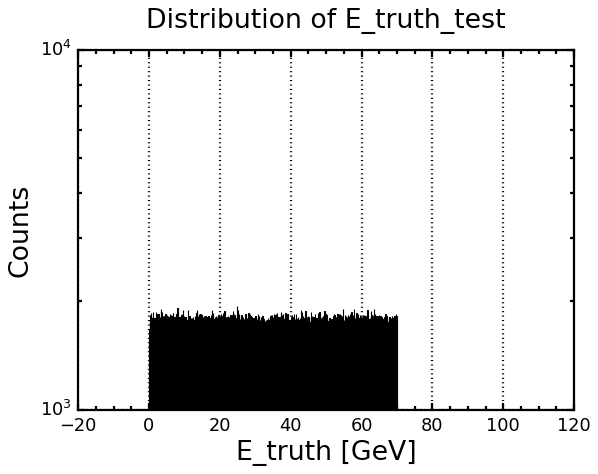

In [3]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()

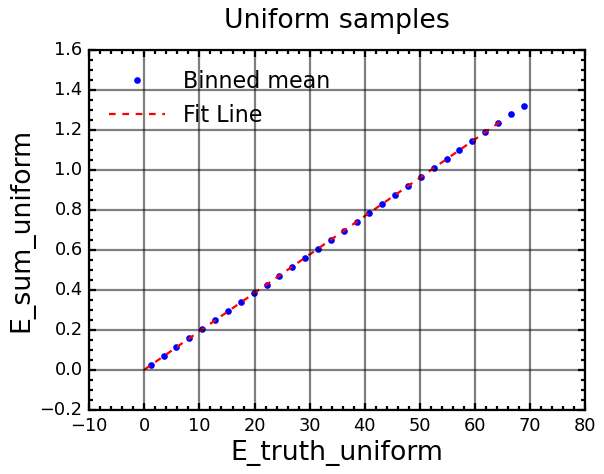

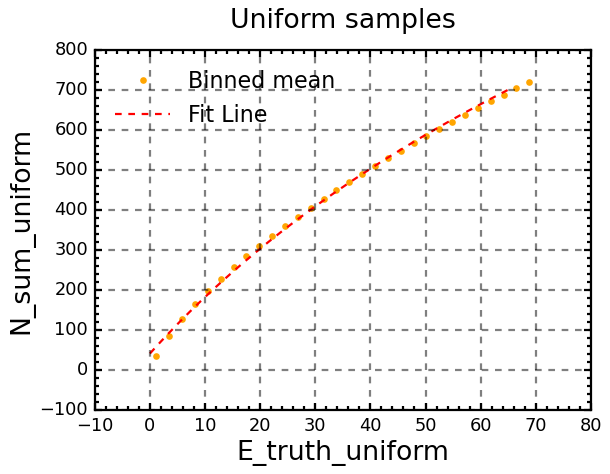

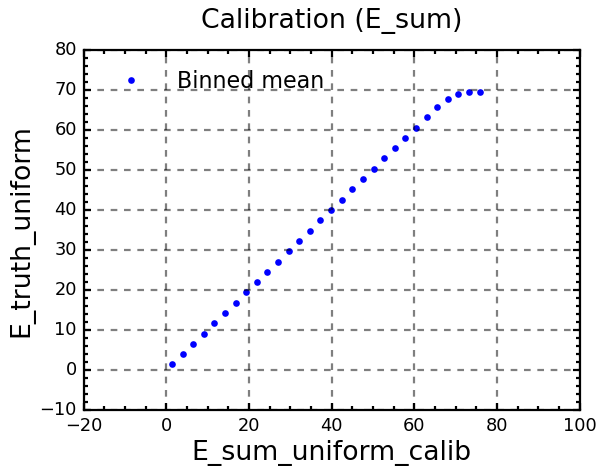

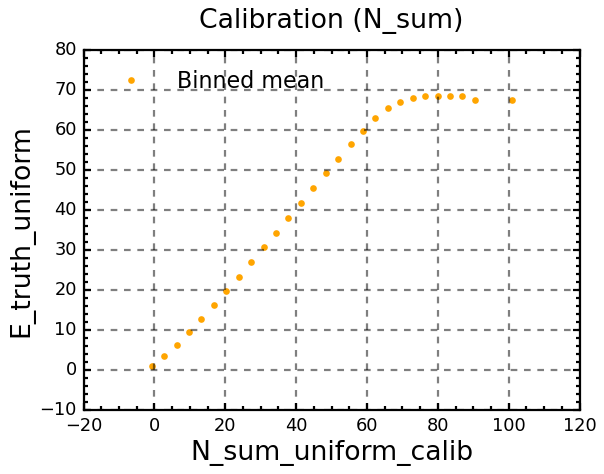

In [ ]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [5]:
class WeightedRelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8, power=1):
        super().__init__()
        self.eps = eps
        self.power = power  # 控制权重下降速度

    def forward(self, y_pred, y_true):
        weight = 1.0 / (y_true + self.eps) ** self.power
        return torch.mean(weight * ((y_true - y_pred) / (y_true + self.eps)) ** 2)
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        denom = torch.clamp(y_true + self.eps, min=1e-6)
        ratio = y_pred / denom
        ratio = torch.clamp(ratio, min=-0.99)  # 保证 log1p 有效
        log = torch.log1p(ratio)
        abs_log = torch.abs(log)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, 0.5 * abs_log)
        #loss = abs_rel*abs_rel + (1-abs_rel)*(rel**2)
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# class MLPRegressor(nn.Module):
#     def __init__(self, input_dim, hidden_dims=[128,64,32], dropout=0.1, activation=nn.ReLU()):
#         super().__init__()
#         layers = []
#         prev_dim = input_dim
#         for h in hidden_dims:
#             layers.append(nn.Linear(prev_dim, h))
#             layers.append(activation)
#             layers.append(nn.Dropout(dropout))
#             prev_dim = h
#         self.backbone = nn.Sequential(*layers)
#         self.output_layer = nn.Linear(prev_dim, 1)
#         self.residual_layer = nn.Linear(prev_dim, 4)
#     def forward(self, x, y_true=None, use_true_residual=False):
#         features = self.backbone(x)
#         y_pred = self.output_layer(features).squeeze(-1)
#         params = self.residual_layer(features)
#         a, b, c, d = params[:,0], params[:,1], params[:,2], params[:,3]
#         a = torch.nn.functional.softplus(params[:,0])*1   
#         b = torch.nn.functional.tanh(params[:,1]) * 1  
#         c = torch.nn.functional.tanh(params[:,2]) * 1
#         d = torch.nn.functional.tanh(params[:,3]) * 1
#         r_pred = a * torch.exp(b * y_pred) + c * y_pred + d
#         y_calib = y_pred / r_pred
#         return y_calib

# ==== Training function ====
def train_mlp(X_train,y_train,X_validate,y_validate,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_validate))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")

    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_validate   = torch.tensor(X_validate, dtype=torch.float32)
    y_validate   = torch.tensor(y_validate, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset   = TensorDataset(X_validate, y_validate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         activation=activation).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Relative MSE)")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model

In [6]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
E_layers_test_exp    = np.exp(E_layers_test_ratio)
N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
EN_layers_test    = E_N_layers_test * N_layers_test

In [14]:

X_train = np.hstack([
    E_layers_uniform, 
    #E_layers_uniform_exp, 
    E_sum_uniform_calib[:, np.newaxis],
    N_layers_uniform, 
    #N_layers_uniform_exp, 
    N_sum_uniform_calib[:, np.newaxis],
    E_N_layers_uniform,
])
X_test = np.hstack(
    [E_layers_test, 
     #E_layers_test_exp, 
     E_sum_test_calib[:,np.newaxis], 
     N_layers_test, 
     #N_layers_test_exp, 
     N_sum_test_calib[:,np.newaxis],
     E_N_layers_test,
])
y_train = E_truth_uniform
y_test = E_truth_test

#Scaling
random_state = 42
val_split = 0.2
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=random_state)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

In [ ]:
ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
for lr in ParameterScan:
  mlp_model= train_mlp(X_train_scaled, y_train,X_validate_scaled, y_validate,
                    activation=nn.PReLU(),
                    hidden_dims=[128,64, 32],
                      dropout=0.1,
                      loss=HuberRelativeLoss(delta=0.1),
                      #loss=nn.MSELoss(),
                      lr=lr,
                      batch_size=4096,
                      epochs=50,
                      patience=10,
                      random_state=random_state)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")


Using device: cuda
Random state: 42
Training samples: 999762, Validation samples: 249941
learning rate: 0.001, batch size: 4096, epochs: 50, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [128, 64, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Epoch 001/50 | Train Loss: 0.077032 | Val Loss: 0.052985| LR: 0.000400


Step 1 Linear fit coeffs: [ 2.59252809e-05 -1.19850411e-03]


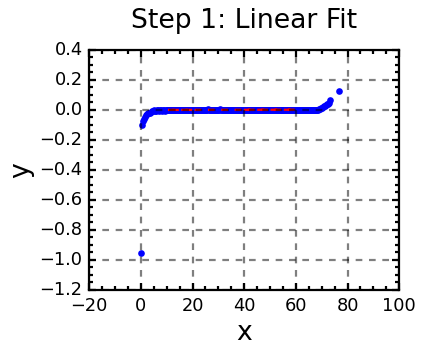

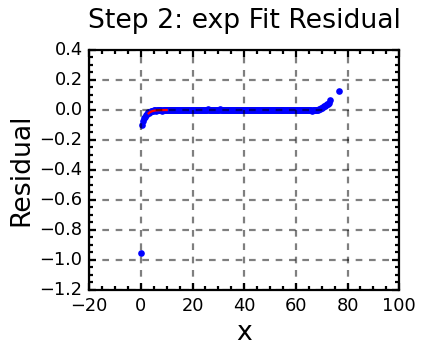

Step 3 Linear fit coeffs: [-2.34063110e-05 -8.78021838e-04]


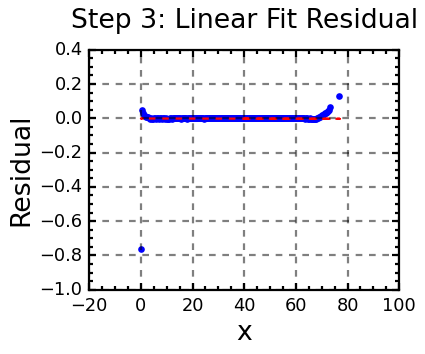

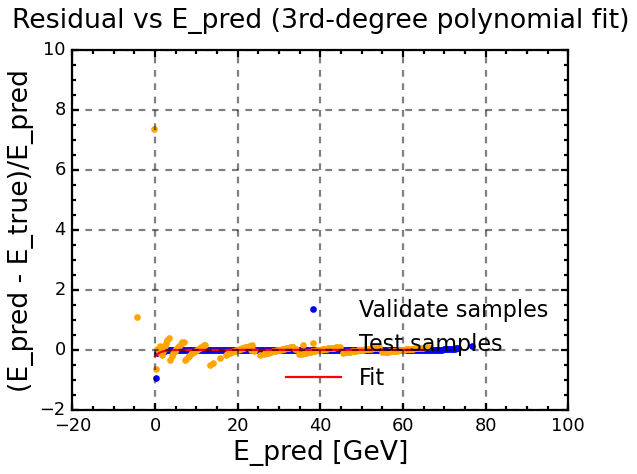

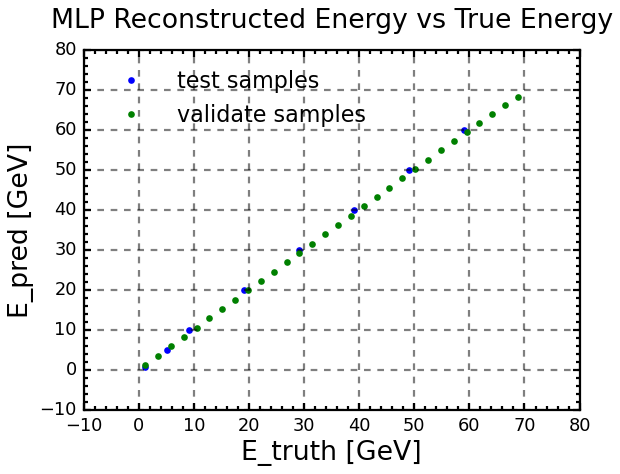

In [ ]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (3, 10)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32).to(device)
y_pred = mlp_model(X_validate_tensor).detach().cpu().numpy()
y_true = y_validate
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_test_mlp = mlp_model(X_test_tensor).detach().cpu().numpy()
# Reco_hist_mlp_all.clear()
# Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_mlp_all.append(Reco_hist_mlp)

fit_range = (0, 65) 
mask = y_pred>0
residual_E = (y_pred[mask] - y_true[mask]) / y_pred[mask]
E_calib_fit = Combined_fit(y_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
x_fit = np.linspace(fit_range[0], fit_range[1], 200)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred (3rd-degree polynomial fit)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

plt.figure(figsize=fig_size)
plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
plot_binned(y_true, y_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [ ]:
# X = np.vstack([X_train_scaled, X_validate_scaled])
# y_pred = mlp_model(torch.tensor(X, dtype=torch.float32).to(device)).detach().cpu().numpy()
# y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
# X_train = np.hstack([
#     E_layers_uniform, 
#     N_layers_uniform, 
#     y_pred_calib[:, np.newaxis],
# ])
# X_test = np.hstack(
#     [E_layers_test, 
#      y_pred_test_mlp_calib[:, np.newaxis],
#      N_layers_test,
# ])
# y_train = E_truth_uniform
# y_test = E_truth_test

# #Scaling
# random_state = 42
# val_split = 0.2
# X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=random_state)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_validate_scaled = scaler.transform(X_validate)

# ParameterScan=[5e-4,]#not used, but the loop is kept for future parameter scanning
# Reco_hist_mlp_all = []
# for lr in ParameterScan:
#   mlp_model2= train_mlp(X_train_scaled, y_train,X_validate_scaled, y_validate,
#                     activation=nn.PReLU(),
#                     hidden_dims=[128,64, 32],
#                       dropout=0.1,
#                       loss=HuberRelativeLoss(delta=0.1),
#                       lr=lr,
#                       batch_size=4096,
#                       epochs=50,
#                       patience=10,
#                       random_state=random_state)
#   device = next(mlp_model2.parameters()).device
#   torch.save(mlp_model2, DataPath_Validate+f"/Models/MLP.pth")

# X_test_scaled = scaler.transform(X_test)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
# with torch.no_grad():
#     y_pred_test_mlp = mlp_model2(X_test_tensor).detach().cpu().numpy()
# Reco_hist_mlp_all.clear()
# Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=50)
# Reco_hist_mlp_all.append(Reco_hist_mlp)

In [ ]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_mlp_all: 1
length of Reco_hist_mlp: 12
Mean: 10.046071420393138, Peak: 10.093533182847601, RMS: 0.5832661392164246
Initial Gamma Fit Parameters: [np.float64(462.77069475881837), np.float64(4.441079334985457), np.float64(7.455740222722325), np.float64(0.5832661392164246)]
Gamma Fit Bounds: lower [np.float64(4.627706947588184), np.float64(-0.5558920665014542), np.float64(-0.25442597772776754), np.float64(0.058326613921642456)], 
 upper [np.float64(2776.6241685529103), np.float64(44.41079334985457), np.float64(21.183610334083486), np.float64(5.832661392164246)]
Gamma Fit Parameters: [4.61074510e+02 4.44107933e+01 6.23207404e+00 8.67297161e-02]
Gamma Fit Peak: 9.997079826582407 ± 0.014891045904018588, Mean: 10.083809542656372 ± 0.01504191351811853, Resolution: 0.057814800370989745 ± 0.0010377718086289215


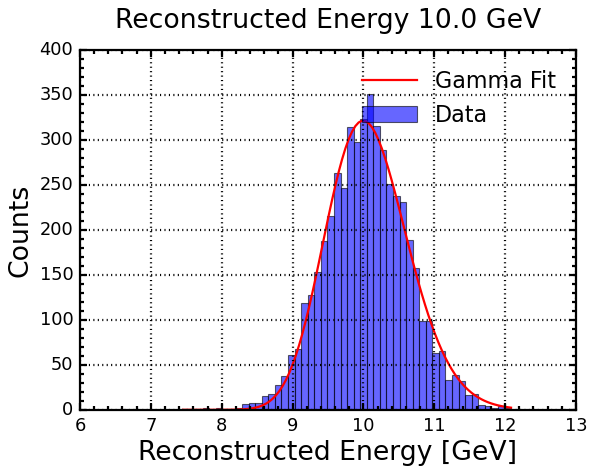

In [ ]:
#This cell is left here for debug
print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist_mlp))
#print(Reco_hist_mlp[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: 0.11925959631792903, Peak: 0.03685962644917287, RMS: 0.1286963391354722
Initial Gamma Fit Parameters: [np.float64(91.93625237108681), np.float64(1.859810418555024), np.float64(-0.12009119603611287), np.float64(0.1286963391354722)]
Gamma Fit Bounds: lower [np.float64(0.9193625237108681), np.float64(-0.8140189581444977), np.float64(-1.0120091196036114), np.float64(0.012869633913547222)], 
 upper [np.float64(551.6175142265208), np.float64(18.59810418555024), np.float64(9.81986320594583), np.float64(1.286963391354722)]
Gamma Fit Parameters: [ 8.83768720e+01  3.35665575e+00 -8.71085253e-02  5.83913402e-02]
Gamma Fit Peak: 0.050499762302759474 ± 0.0023489872487259156, Mean: 0.10889110254900507 ± 0.002736960899425733, Resolution: 2.1184221623082102 ± 0.1319126160040527


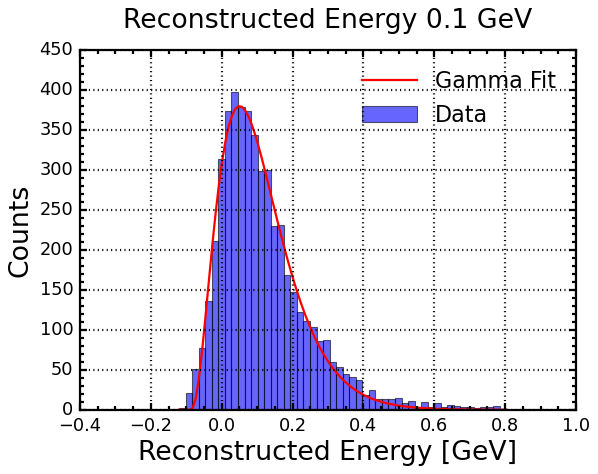

Mean: 0.30070495143418746, Peak: 0.18070939564725239, RMS: 0.15180087436832945
Initial Gamma Fit Parameters: [np.float64(118.02821193436334), np.float64(2.582718870406858), np.float64(-0.09135403134115774), np.float64(0.15180087436832945)]
Gamma Fit Bounds: lower [np.float64(1.1802821193436335), np.float64(-0.7417281129593142), np.float64(-1.0091354031341158), np.float64(0.015180087436832947)], 
 upper [np.float64(708.16927160618), np.float64(25.82718870406858), np.float64(9.862968952988263), np.float64(1.5180087436832945)]
Gamma Fit Parameters: [ 1.16734112e+02  5.25977827e+00 -3.03542111e-02  6.20272774e-02]
Gamma Fit Peak: 0.23386823752294345 ± 0.0029303431933878853, Mean: 0.2958955149287897 ± 0.0031993287799922786, Resolution: 0.6082683150942393 ± 0.01709458331865204


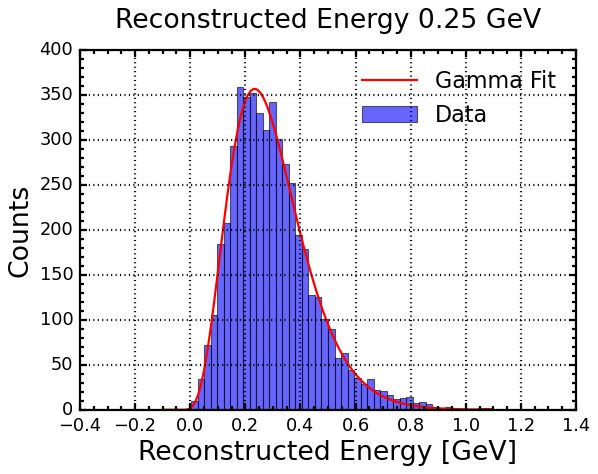

Mean: 0.553837987132438, Peak: 0.524615067849917, RMS: 0.17323813825074982
Initial Gamma Fit Parameters: [np.float64(183.57988489017598), np.float64(3.666385085841642), np.float64(-0.08131973924908356), np.float64(0.17323813825074982)]
Gamma Fit Bounds: lower [np.float64(1.8357988489017598), np.float64(-0.6333614914158359), np.float64(-1.0081319739249084), np.float64(0.017323813825074984)], 
 upper [np.float64(1101.4793093410558), np.float64(36.66385085841642), np.float64(9.878020391126375), np.float64(1.7323813825074983)]
Gamma Fit Parameters: [ 1.81660742e+02  1.39376594e+01 -5.59964758e-02  4.35511835e-02]
Gamma Fit Peak: 0.5074539011851606 ± 0.0026149567552008523, Mean: 0.551005084694066 ± 0.002695214693463664, Resolution: 0.32040426533699096 ± 0.004836078328713887


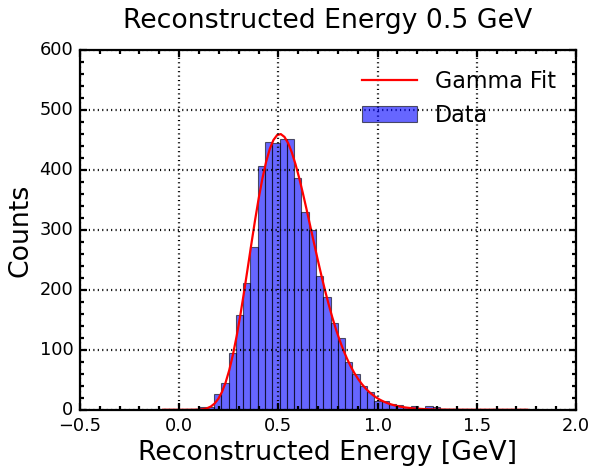

Mean: 1.0560757823566504, Peak: 1.0058947237495266, RMS: 0.20374983864156965
Initial Gamma Fit Parameters: [np.float64(158.71721361512246), np.float64(2.9732658174034037), np.float64(0.4502733518222123), np.float64(0.20374983864156965)]
Gamma Fit Bounds: lower [np.float64(1.5871721361512245), np.float64(-0.7026734182596597), np.float64(-0.9549726648177788), np.float64(0.020374983864156967)], 
 upper [np.float64(952.3032816907348), np.float64(29.732658174034036), np.float64(10.675410027733319), np.float64(2.0374983864156966)]
Gamma Fit Parameters: [1.57742564e+02 2.27247098e+01 1.08071015e-01 4.16994373e-02]
Gamma Fit Peak: 1.0139791896934942 ± 0.0024345219899903764, Mean: 1.055678627039934 ± 0.002479199512204245, Resolution: 0.19604254241087266 ± 0.0019307971209790184


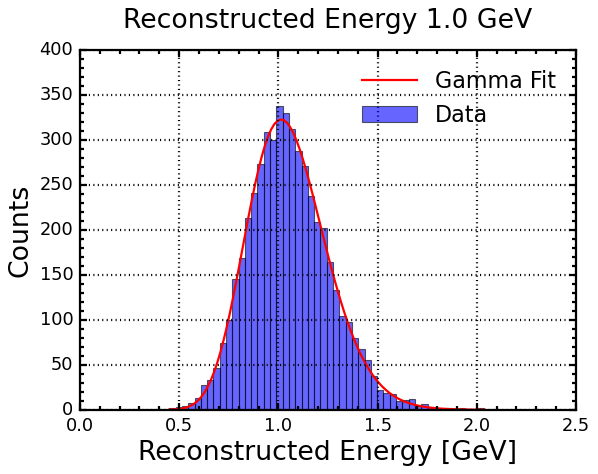

Mean: 2.0516595244348794, Peak: 2.0687263016861346, RMS: 0.25674043322868306
Initial Gamma Fit Parameters: [np.float64(220.18522487126936), np.float64(4.136694154275581), np.float64(0.9896028751316058), np.float64(0.25674043322868306)]
Gamma Fit Bounds: lower [np.float64(2.2018522487126937), np.float64(-0.5863305845724418), np.float64(-0.9010397124868395), np.float64(0.02567404332286831)], 
 upper [np.float64(1321.111349227616), np.float64(41.36694154275581), np.float64(11.484404312697409), np.float64(2.5674043322868307)]
Gamma Fit Parameters: [2.20468050e+02 4.13669415e+01 3.96489489e-01 4.01094454e-02]
Gamma Fit Peak: 2.015585125590497 ± 0.005797053906970866, Mean: 2.055694570953889 ± 0.005854730188628038, Resolution: 0.12798887394527164 ± 0.0020842261442219315


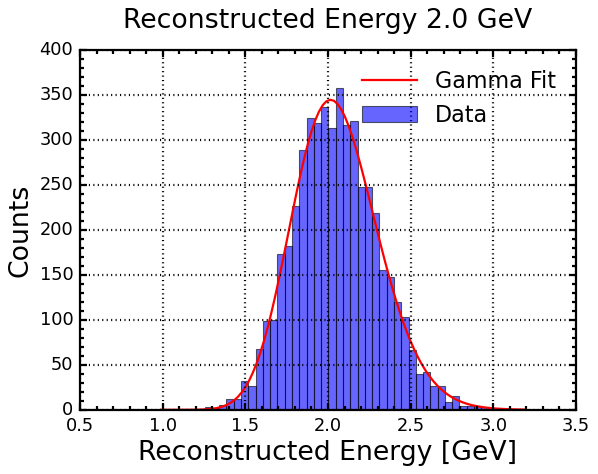

Mean: 5.024379951857818, Peak: 4.965811112139147, RMS: 0.40597672198517704
Initial Gamma Fit Parameters: [np.float64(316.59860764404385), np.float64(3.1862674281381493), np.float64(3.7308295460141516), np.float64(0.40597672198517704)]
Gamma Fit Bounds: lower [np.float64(3.1659860764404386), np.float64(-0.681373257186185), np.float64(-0.6269170453985848), np.float64(0.040597672198517704)], 
 upper [np.float64(1899.5916458642632), np.float64(31.862674281381494), np.float64(15.596244319021228), np.float64(4.0597672198517705)]
Gamma Fit Parameters: [3.18864840e+02 3.18626743e+01 2.67942121e+00 7.40176269e-02]
Gamma Fit Peak: 4.963803124101424 ± 0.006535967417978137, Mean: 5.037820751022453 ± 0.006620570499022908, Resolution: 0.08417085156681169 ± 0.0009555275325078531


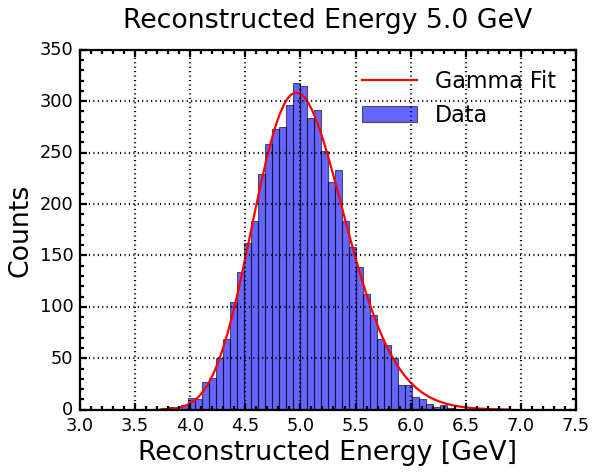

Mean: 10.046071420393138, Peak: 10.093533182847601, RMS: 0.5832661392164246
Initial Gamma Fit Parameters: [np.float64(462.77069475881837), np.float64(4.441079334985457), np.float64(7.455740222722325), np.float64(0.5832661392164246)]
Gamma Fit Bounds: lower [np.float64(4.627706947588184), np.float64(-0.5558920665014542), np.float64(-0.25442597772776754), np.float64(0.058326613921642456)], 
 upper [np.float64(2776.6241685529103), np.float64(44.41079334985457), np.float64(21.183610334083486), np.float64(5.832661392164246)]
Gamma Fit Parameters: [4.61074510e+02 4.44107933e+01 6.23207404e+00 8.67297161e-02]
Gamma Fit Peak: 9.997079826582407 ± 0.014891045904018588, Mean: 10.083809542656372 ± 0.01504191351811853, Resolution: 0.057814800370989745 ± 0.0010377718086289215


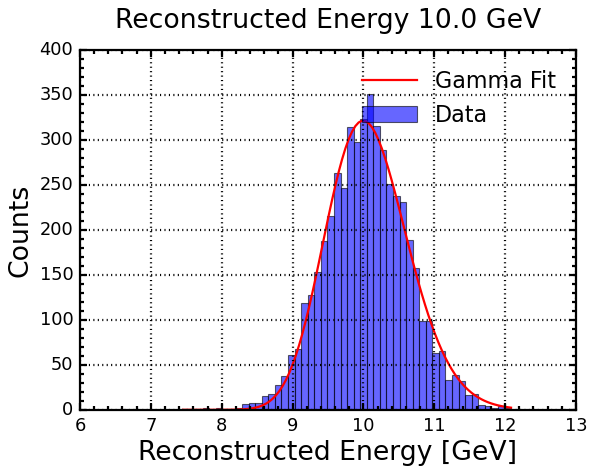

Mean: 20.06391764891873, Peak: 20.009803450593918, RMS: 0.8296620315179276
Initial Gamma Fit Parameters: [np.float64(675.9539865924161), np.float64(3.5706844913012876), np.float64(17.101456299956144), np.float64(0.8296620315179276)]
Gamma Fit Bounds: lower [np.float64(6.759539865924161), np.float64(-0.6429315508698712), np.float64(0.7101456299956146), np.float64(0.08296620315179276)], 
 upper [np.float64(4055.723919554496), np.float64(35.70684491301287), np.float64(35.65218444993422), np.float64(8.296620315179275)]
Gamma Fit Parameters: [6.73968289e+02 3.57068449e+01 1.51833875e+01 1.38018288e-01]
Gamma Fit Peak: 19.973566830141714 ± 0.01984510924820079, Mean: 20.111585118283774 ± 0.020073531200519797, Resolution: 0.0412911280860868 ± 0.0006994557645114977


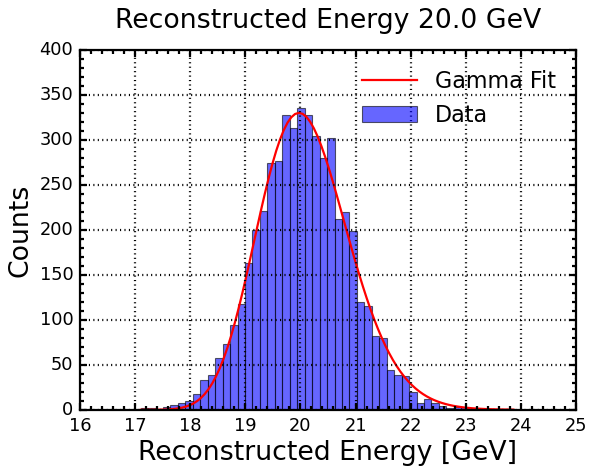

Mean: 30.13353665126241, Peak: 30.118807130197453, RMS: 1.0338151890522724
Initial Gamma Fit Parameters: [np.float64(881.6524735103397), np.float64(4.537782845324191), np.float64(25.442307821145423), np.float64(1.0338151890522724)]
Gamma Fit Bounds: lower [np.float64(8.816524735103398), np.float64(-0.5462217154675808), np.float64(1.5442307821145427), np.float64(0.10338151890522725)], 
 upper [np.float64(5289.914841062038), np.float64(45.37782845324191), np.float64(48.16346173171814), np.float64(10.338151890522724)]
Gamma Fit Parameters: [8.80934945e+02 4.53778285e+01 2.32203805e+01 1.53784691e-01]
Gamma Fit Peak: 30.045011164081615 ± 0.022451218274531802, Mean: 30.198795854611525 ± 0.022656154257519875, Resolution: 0.03447962928616227 ± 0.000514660644800519


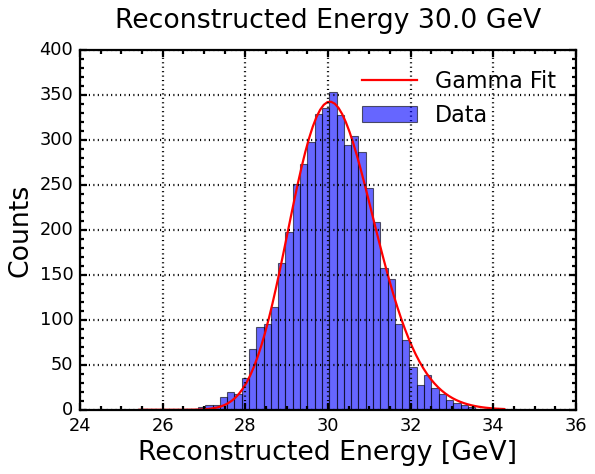

Mean: 40.130736109226554, Peak: 40.18378487867088, RMS: 1.1810923322350908
Initial Gamma Fit Parameters: [np.float64(1063.5300745700915), np.float64(4.909613909831113), np.float64(34.33202876609028), np.float64(1.1810923322350908)]
Gamma Fit Bounds: lower [np.float64(10.635300745700915), np.float64(-0.5090386090168887), np.float64(2.4332028766090286), np.float64(0.11810923322350908)], 
 upper [np.float64(6381.180447420549), np.float64(49.09613909831113), np.float64(61.49804314913543), np.float64(11.810923322350908)]
Gamma Fit Parameters: [1.06289083e+03 4.90961391e+01 3.19291140e+01 1.68359474e-01]
Gamma Fit Peak: 40.0265547223414 ± 0.023922608186393572, Mean: 40.1949141964426 ± 0.024123422018015782, Resolution: 0.029472231574000855 ± 0.0004086142524578135


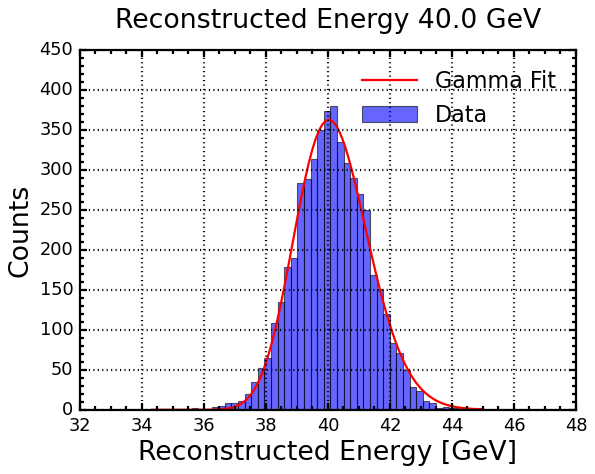

Mean: 50.22901797133166, Peak: 50.41759450342107, RMS: 1.3213108678268537
Initial Gamma Fit Parameters: [np.float64(903.3022283862275), np.float64(3.4813026080860263), np.float64(45.62913500107362), np.float64(1.3213108678268537)]
Gamma Fit Bounds: lower [np.float64(9.033022283862275), np.float64(-0.6518697391913973), np.float64(3.5629135001073626), np.float64(0.13213108678268537)], 
 upper [np.float64(5419.813370317365), np.float64(34.81302608086026), np.float64(78.44370250161043), np.float64(13.213108678268537)]
Gamma Fit Parameters: [9.01673713e+02 3.48130261e+01 4.24769276e+01 2.25420373e-01]
Gamma Fit Peak: 50.09907251328519 ± 0.044922452635343085, Mean: 50.3244928865937 ± 0.045556414857256755, Resolution: 0.026548156343733222 ± 0.0006297554587807796


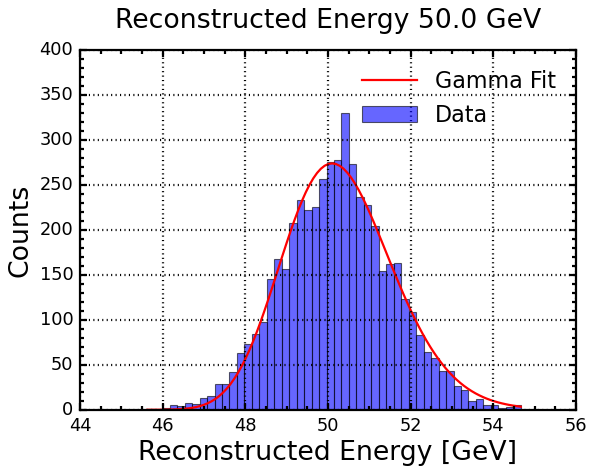

Mean: 60.242848472842226, Peak: 59.967156107161514, RMS: 1.4360307091767646
Initial Gamma Fit Parameters: [np.float64(1131.1036765807453), np.float64(3.5795969305387985), np.float64(55.102437354113626), np.float64(1.4360307091767646)]
Gamma Fit Bounds: lower [np.float64(11.311036765807453), np.float64(-0.6420403069461201), np.float64(4.510243735411363), np.float64(0.14360307091767646)], 
 upper [np.float64(6786.622059484472), np.float64(35.795969305387985), np.float64(92.65365603117044), np.float64(14.360307091767645)]
Gamma Fit Parameters: [1.13051146e+03 3.57959693e+01 5.16724706e+01 2.42617817e-01]
Gamma Fit Peak: 60.11459276115067 ± 0.03398885672070452, Mean: 60.35721057834512 ± 0.03438015674766599, Resolution: 0.02414681446862031 ± 0.000395190889063561


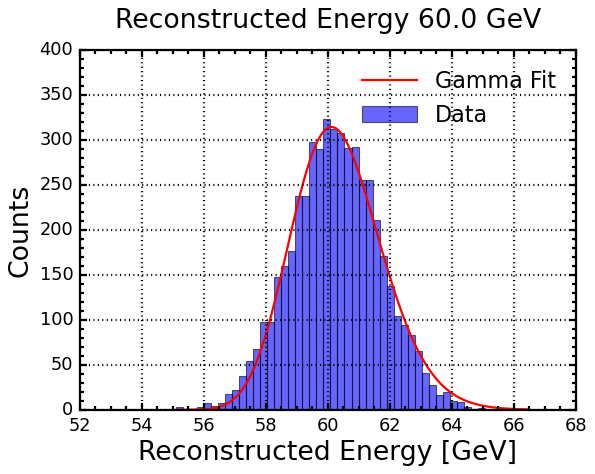

Saved fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Reco_Results/RecoE_MLP_Fit.csv


In [ ]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
for i_para, para in enumerate(ParameterScan):
    if i_para != 0:
        continue  # 
    #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
    outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
    OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
    print(f"Saved fit results to {outputfile_name}")